<a href="https://colab.research.google.com/github/silverkkang/LG-DXSCHOOL/blob/main/KoElectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install transformers scikit-learn pandas tqdm

import pandas as pd
import torch
from transformers import ElectraModel, ElectraTokenizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
warnings.filterwarnings('ignore')


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Using device: {device}")

🖥️  Using device: cuda


In [39]:
file_name = '/content/drive/MyDrive/진짜 최종종합본.csv'
df = pd.read_csv(file_name)

In [40]:
print("\n" + "="*60)
print("📂 데이터 로드 완료")
print("="*60)
print(f"원본 데이터: {len(df):,}개")
print(f"\n사용 가능한 컬럼: {df.columns.tolist()}")
print(f"\n데이터 미리보기:")
print(df.head(3))


📂 데이터 로드 완료
원본 데이터: 90,193개

사용 가능한 컬럼: ['Unnamed: 0', 'title', 'contents', 'url', 'date', 'nouns']

데이터 미리보기:
   Unnamed: 0                                 title  \
0           0          소음순 돌출 되어 불편함 겪어보신 분 계실까요..?   
1           1                        임부복 바지 도와주세요 ㅠ   
2           2  모유수유 분유 상관 없이 수유쿠션은 쓰나요? 둘중 뭐가 편할까요!   

                                            contents  \
0  지금 임신 5주차예요 ~예전에 산부인과에서 검사하면서소음순이 비대칭이네 라고 원장님...   
1  스토퍼형 하나사봤는데 조이면 조인곳이 너무 불편하고안조이면 흘러내리고 ㅜ원피스 사긴...   
2         가격 상관 없이 뭐가 나아보이나요?수유 어떻게 할지 모르겠는데 잘쓸까요,,?   

                                                 url        date  nouns  
0  https://cafe.naver.com/f-e/cafes/10094499/arti...  2025-11-15    NaN  
1  https://cafe.naver.com/f-e/cafes/10094499/arti...  2025-11-15    NaN  
2  https://cafe.naver.com/f-e/cafes/10094499/arti...  2025-11-15    NaN  


In [42]:
TEXT_COLUMN = 'contents'
if TEXT_COLUMN not in df.columns:
    raise ValueError(f"❌ '{TEXT_COLUMN}' 컬럼을 찾을 수 없습니다. 위의 컬럼 목록에서 선택하세요.")

In [25]:
if TEXT_COLUMN in df.columns:
    original_len = len(df)
    df = df.dropna(subset=[TEXT_COLUMN])
    df = df[df[TEXT_COLUMN].str.strip() != '']
    df = df.reset_index(drop=True)
    texts = df[TEXT_COLUMN].tolist()
    print(f"\n전처리 완료: {original_len}개 → {len(texts)}개") # texts 변수 생성 확인


전처리 완료: 90193개 → 90159개


In [26]:
model_name = "monologg/koelectra-base-v3-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(model_name)
model = ElectraModel.from_pretrained(model_name).to(device)
model.eval()

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(35000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0

In [27]:
text_lengths = [len(tokenizer.encode(text)) for text in texts[:1000]]  # 샘플링
avg_length = np.mean(text_lengths)
p95_length = np.percentile(text_lengths, 95)
print(f"\n텍스트 길이 분석 - 평균: {avg_length:.0f}, 95%: {p95_length:.0f}")
max_length = min(int(p95_length), 512)

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors



텍스트 길이 분석 - 평균: 175, 95%: 568


In [28]:
def get_electra_embeddings(texts, batch_size=16, max_length=128):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        # Mean Pooling
        last_hidden_states = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']

        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
        sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        mean_pooled_embeddings = sum_embeddings / sum_mask

        all_embeddings.extend(mean_pooled_embeddings.cpu().numpy())

        # GPU 메모리 정리
        del inputs, outputs, last_hidden_states
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    return np.array(all_embeddings)

In [29]:
# 임베딩 생성
embeddings = get_electra_embeddings(texts, batch_size=16, max_length=max_length)
print(f"\n임베딩 완료: {embeddings.shape}")

Embedding: 100%|██████████| 5635/5635 [49:08<00:00,  1.91it/s]



임베딩 완료: (90159, 768)


In [30]:
# 6. 자동 최적 K 찾기
max_k = min(15, len(texts) // 100)  # 데이터 크기에 맞게 조정
k_range = range(2, max_k + 1)
silhouette_scores = []

In [31]:
print(f"\n최적 K 탐색 (2 ~ {max_k})...")
for k in tqdm(k_range, desc="Finding K"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    clusters = kmeans.fit_predict(embeddings)

    # 샘플링으로 속도 개선
    if len(embeddings) > 5000:
        sample_size = min(5000, len(embeddings))
        sample_indices = np.random.choice(len(embeddings), sample_size, replace=False)
        score = silhouette_score(embeddings[sample_indices], clusters[sample_indices])
    else:
        score = silhouette_score(embeddings, clusters)

    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")


최적 K 탐색 (2 ~ 15)...


Finding K:   7%|▋         | 1/14 [00:16<03:28, 16.02s/it]

K=2: Silhouette Score = 0.5214


Finding K:  14%|█▍        | 2/14 [00:37<03:52, 19.41s/it]

K=3: Silhouette Score = 0.3346


Finding K:  21%|██▏       | 3/14 [01:06<04:18, 23.51s/it]

K=4: Silhouette Score = 0.2788


Finding K:  29%|██▊       | 4/14 [01:46<05:02, 30.29s/it]

K=5: Silhouette Score = 0.1688


Finding K:  36%|███▌      | 5/14 [02:33<05:26, 36.24s/it]

K=6: Silhouette Score = 0.1429


Finding K:  43%|████▎     | 6/14 [03:34<05:55, 44.43s/it]

K=7: Silhouette Score = 0.1214


Finding K:  50%|█████     | 7/14 [04:43<06:08, 52.71s/it]

K=8: Silhouette Score = 0.1144


Finding K:  57%|█████▋    | 8/14 [06:26<06:51, 68.53s/it]

K=9: Silhouette Score = 0.1140


Finding K:  64%|██████▍   | 9/14 [08:03<06:28, 77.66s/it]

K=10: Silhouette Score = 0.1025


Finding K:  71%|███████▏  | 10/14 [10:14<06:15, 93.94s/it]

K=11: Silhouette Score = 0.0969


Finding K:  79%|███████▊  | 11/14 [12:12<05:03, 101.31s/it]

K=12: Silhouette Score = 0.0934


Finding K:  86%|████████▌ | 12/14 [14:28<03:43, 111.98s/it]

K=13: Silhouette Score = 0.0919


Finding K:  93%|█████████▎| 13/14 [16:45<01:59, 119.47s/it]

K=14: Silhouette Score = 0.0870


Finding K: 100%|██████████| 14/14 [19:13<00:00, 82.41s/it] 

K=15: Silhouette Score = 0.0845


([<matplotlib.axis.XTick at 0x7a9f196dbd70>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

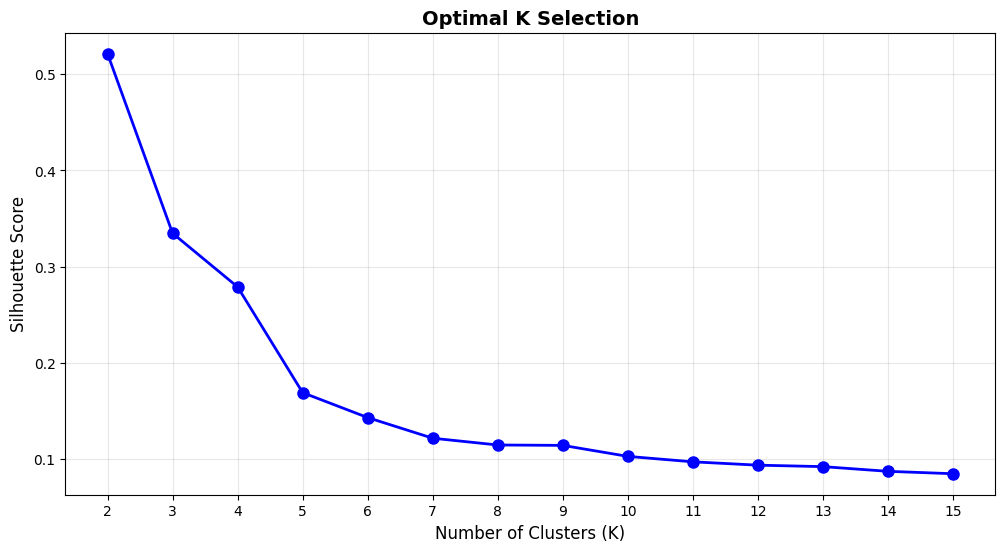

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Optimal K Selection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

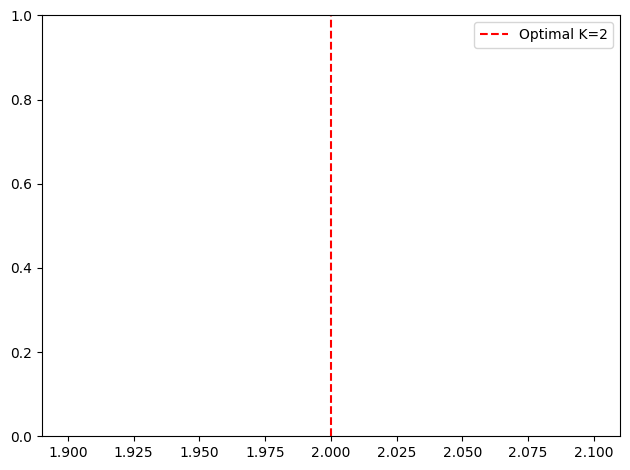

In [33]:
optimal_idx = np.argmax(silhouette_scores)
optimal_k = list(k_range)[optimal_idx]
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
OPTIMAL_K = optimal_k
print(f"\n✅ 자동 선택된 최적 K = {OPTIMAL_K} (Score: {max(silhouette_scores):.4f})")


✅ 자동 선택된 최적 K = 2 (Score: 0.5214)


In [35]:
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=20, max_iter=300)
cluster_labels = kmeans_final.fit_predict(embeddings)

In [36]:
# 현재 코드 그대로 실행
# (이미 기본 전처리 포함됨)

# 완료 후 이 코드로 데이터 품질 확인:
print("\n" + "="*50)
print("📊 데이터 품질 확인")
print("="*50)

# 중복 체크
duplicate_count = df[TEXT_COLUMN].duplicated().sum()
print(f"중복: {duplicate_count}개 ({duplicate_count/len(df)*100:.1f}%)")

# HTML 태그 체크
html_count = df[TEXT_COLUMN].str.contains('<[^>]+>', regex=True, na=False).sum()
print(f"HTML 태그: {html_count}개 ({html_count/len(df)*100:.1f}%)")

# 샘플 데이터 확인
print("\n샘플 3개:")
for i, text in enumerate(df[TEXT_COLUMN].head(3), 1):
    print(f"{i}. {text[:100]}")

# 판단 기준
total_noise = duplicate_count + html_count
if total_noise / len(df) < 0.1:
    print("\n✅ 데이터가 깨끗합니다! 그대로 진행 OK")
else:
    print(f"\n⚠️ 노이즈 {total_noise/len(df)*100:.1f}% 발견. 추가 전처리 권장")


📊 데이터 품질 확인
중복: 38개 (0.0%)
HTML 태그: 2608개 (2.9%)

샘플 3개:
1. 지금 임신 5주차예요 ~예전에 산부인과에서 검사하면서소음순이 비대칭이네 라고 원장님이 혼잣말 한걸 들은적 있어요저한테 물어본것도 아니고 해서 딱히 신경 안쓰고 있었는데요 간혹 속옷
2. 스토퍼형 하나사봤는데 조이면 조인곳이 너무 불편하고안조이면 흘러내리고 ㅜ원피스 사긴샀는데 키가작아 기장이 너무길어서 종류가 한정적이에요ㅠ유니클로 니트팬츠는 재고가 거의없네요.. 입
3. 가격 상관 없이 뭐가 나아보이나요?수유 어떻게 할지 모르겠는데 잘쓸까요,,?

✅ 데이터가 깨끗합니다! 그대로 진행 OK
